# EDA and Cleaning

In [1]:
import requests
import time
import pandas as pd
import json
import psycopg2 as pg2
from psycopg2.extras import RealDictCursor, Json
import matplotlib.pyplot as plt
import numpy as np
from xml.etree import ElementTree
import re

In [2]:
%run ../bx_sql.py

## Configure PostgreSQL Server with Docker

In [3]:
def con_cur_to_db(dbname=DBNAME, dict_cur=None):
    con = pg2.connect(host=IP_ADDRESS,
                  dbname=dbname,
                  user=USER,
                  password=PASSWORD)
    if dict_cur:
        cur = con.cursor(cursor_factory=RealDictCursor)
    else:
        cur = con.cursor()
    return con, cur
    
def execute_query(query, dbname=DBNAME, dict_cur=None, command=False):
    con, cur = con_cur_to_db(dbname, dict_cur)
    cur.execute(f'{query}')
    if not command:
        data = cur.fetchall()
        con.close()
        return data
    con.commit() #sends to server
    con.close() #closes server connection

def insert_entry_json(data, tablename=None):
    con, cur = con_cur_to_db()
    for x in data:
        cur.execute(f'INSERT INTO {tablename} (data) VALUES ({Json(x)});')
    con.commit()
    con.close()

## Retrieve Data from PostgreSQL Database

### Books

In [4]:
book_query = '''SELECT * FROM books;
'''

book_results = execute_query(book_query, dict_cur=True)

In [5]:
book_df = pd.DataFrame(book_results)

In [6]:
len(book_df)

271379

In [7]:
book_df.head()

,book_author,book_title,image_url_l,image_url_m,image_url_s,isbn,publisher,year_of_publication
0,Mark P. O. Morford,Classical Mythology,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,0195153448,Oxford University Press,2002
1,Richard Bruce Wright,Clara Callan,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,0002005018,HarperFlamingo Canada,2001
2,Carlo D'Este,Decision in Normandy,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,0060973129,HarperPerennial,1991
3,Gina Bari Kolata,Flu: The Story of the Great Influenza Pandemic...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,0374157065,Farrar Straus Giroux,1999
4,E. J. W. Barber,The Mummies of Urumchi,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,0393045218,W. W. Norton &amp; Company,1999


In [8]:
book_df.drop(columns=['image_url_l', 'image_url_m', 'image_url_s'], inplace=True)

In [9]:
book_df.head()

,book_author,book_title,isbn,publisher,year_of_publication
0,Mark P. O. Morford,Classical Mythology,0195153448,Oxford University Press,2002
1,Richard Bruce Wright,Clara Callan,0002005018,HarperFlamingo Canada,2001
2,Carlo D'Este,Decision in Normandy,0060973129,HarperPerennial,1991
3,Gina Bari Kolata,Flu: The Story of the Great Influenza Pandemic...,0374157065,Farrar Straus Giroux,1999
4,E. J. W. Barber,The Mummies of Urumchi,0393045218,W. W. Norton &amp; Company,1999


In [10]:
book_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271379 entries, 0 to 271378
Data columns (total 5 columns):
book_author            271378 non-null object
book_title             271379 non-null object
isbn                   271379 non-null object
publisher              271377 non-null object
year_of_publication    271379 non-null int64
dtypes: int64(1), object(4)
memory usage: 10.4+ MB


#### Missing Data

In [11]:
book_df.isna().sum()

book_author            1
book_title             0
isbn                   0
publisher              2
year_of_publication    0
dtype: int64

##### Author

In [12]:
book_df[book_df['book_author'].isna()]

,book_author,book_title,isbn,publisher,year_of_publication
187714,None,The Credit Suisse Guide to Managing Your Perso...,9627982032,Edinburgh Financial Publishing,1995


[Amazon (The Credit Suisse Guide to Managing Your Personal Wealth)](https://www.amazon.ca/Credit-Suisse-Managing-Personal-Wealth/dp/9627982075)

##### Publisher

In [13]:
book_df.loc[187714, ['book_author']] = 'Larissa Anne Downes'

In [14]:
book_df[book_df['publisher'].isna()]

,book_author,book_title,isbn,publisher,year_of_publication
128920,Elaine Corvidae,Tyrant Moon,193169656X,None,2002
129068,Linnea Sinclair,Finders Keepers,1931696993,None,2001


Sources:
-  [AbeBooks (Tyrant Moon)](https://www.abebooks.com/9781931696562/Tyrant-Moon-Elaine-Corvidae-193169656X/plp)
-  [Google Books (Finders Keepers)](https://books.google.com/books/about/Finders_Keepers.html?id=M9pbPgAACAAJ)

In [15]:
book_df.loc[128920, ['publisher']] = 'Novelbooks Incorporated'

In [16]:
book_df.loc[129068, ['publisher']] = 'Novelbooks Incorporated'

##### Year of Publication ????

In [17]:
np.asarray(sorted(book_df['year_of_publication'].unique()))

array([   0, 1376, 1378, 1806, 1897, 1900, 1901, 1902, 1904, 1906, 1908,
       1909, 1910, 1911, 1914, 1917, 1919, 1920, 1921, 1922, 1923, 1924,
       1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935,
       1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946,
       1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957,
       1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968,
       1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979,
       1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990,
       1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005, 2006, 2008, 2010, 2011, 2012, 2020, 2021,
       2024, 2026, 2030, 2037, 2038, 2050])

In [18]:
book_df[book_df['year_of_publication'] == 0].head()

,book_author,book_title,isbn,publisher,year_of_publication
177,Schiller,Kabale Und Liebe,3150000335,"Philipp Reclam, Jun Verlag GmbH",0
189,Gabriel Garcia Marquez,Die Liebe in Den Zelten,342311360X,Deutscher Taschenbuch Verlag (DTV),0
289,Barbara Kingsolver,Poisonwood Bible Edition Uk,0571197639,Faber Faber Inc,0
352,Golding,"Herr Der Fliegen (Fiction, Poetry and Drama)",3596214629,Fischer Taschenbuch Verlag GmbH,0
542,P Coelho,Biblioteca Universale Rizzoli: Sulla Sponda De...,8845229041,Fabbri - RCS Libri,0


In [19]:
book_df[book_df['year_of_publication'] >= 2005].head()

,book_author,book_title,isbn,publisher,year_of_publication
3547,Grant Naylor,Red Dwarf,0140124373,Penguin Books Ltd,2005
12799,Kathleen E. Woodiwiss,A Rose in Winter,0380816792,Harper Mass Market Paperbacks,2011
26187,Frances Sakoian,The Astrologer's Handbook,006272004X,HarperResource,2005
30030,Kitty Kelley,The Royals,068160204X,Bausch &amp; Lombard,2020
37505,Coville,MY TEACHER FRIED MY BRAINS (RACK SIZE) (MY TEA...,0671746103,Aladdin,2030


In [20]:
# url = 'https://www.goodreads.com/book/isbn/ISBN?format=xml&isbn=3150000335&key=prkLqGzgF7KgNNy3VqgJpQ'

##### ISBN

In [20]:
book_df['isbn'].nunique()

271379

##### Title

In [21]:
book_df['book_title'].nunique()

242154

In [22]:
book_df[book_df['book_title'].duplicated()].head()

,book_author,book_title,isbn,publisher,year_of_publication
240,Dan Brown,Angels &amp; Demons,0743486226,Atria,2003
356,Roald Dahl,James and the Giant Peach,0140374248,Penguin USA (Paper),2000
406,Sebastian Junger,The Perfect Storm : A True Story of Men Agains...,006101351X,HarperTorch,1998
457,John Grisham,The Firm,044021145X,Bantam Dell Publishing Group,1992
476,T. Coraghessan Boyle,The Tortilla Curtain,014023828X,Penguin Books,1996


In [23]:
book_df[book_df['book_title'] == 'Angels &amp; Demons']

,book_author,book_title,isbn,publisher,year_of_publication
119,Dan Brown,Angels &amp; Demons,0671027360,Pocket Star,2001
240,Dan Brown,Angels &amp; Demons,0743486226,Atria,2003
28021,Dan Brown,Angels &amp; Demons,0671027352,Atria,2000
36952,Dan Brown,Angels &amp; Demons,0743535774,Audioworks,2003
163571,Dan Brown,Angels &amp; Demons,0743535766,Simon &amp; Schuster Audio,2003


**Merge with users_df and change `isbn` to only one**

### Users

In [24]:
user_query = '''SELECT * FROM users;
'''

user_results = execute_query(user_query, dict_cur=True)

In [76]:
users_df = pd.DataFrame(user_results)

In [26]:
users_df.head()

,age,location,user_id
0,None,"nyc, new york, usa",1
1,18.0,"stockton, california, usa",2
2,None,"moscow, yukon territory, russia",3
3,17.0,"porto, v.n.gaia, portugal",4
4,None,"farnborough, hants, united kingdom",5


In [27]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
age         168096 non-null object
location    278858 non-null object
user_id     278858 non-null int64
dtypes: int64(1), object(2)
memory usage: 6.4+ MB


#### User ID

In [75]:
users_df['user_id'].nunique() == len(users_df)

True

#### Age

In [91]:
np.asarray(users_df['age'].unique())

array([None, Decimal('18.0'), Decimal('17.0'), Decimal('61.0'),
       Decimal('26.0'), Decimal('14.0'), Decimal('25.0'), Decimal('19.0'),
       Decimal('46.0'), Decimal('55.0'), Decimal('32.0'), Decimal('24.0'),
       Decimal('20.0'), Decimal('34.0'), Decimal('23.0'), Decimal('51.0'),
       Decimal('31.0'), Decimal('21.0'), Decimal('44.0'), Decimal('30.0'),
       Decimal('57.0'), Decimal('43.0'), Decimal('37.0'), Decimal('41.0'),
       Decimal('54.0'), Decimal('42.0'), Decimal('50.0'), Decimal('39.0'),
       Decimal('53.0'), Decimal('47.0'), Decimal('36.0'), Decimal('28.0'),
       Decimal('35.0'), Decimal('13.0'), Decimal('58.0'), Decimal('49.0'),
       Decimal('38.0'), Decimal('45.0'), Decimal('62.0'), Decimal('63.0'),
       Decimal('27.0'), Decimal('33.0'), Decimal('29.0'), Decimal('66.0'),
       Decimal('40.0'), Decimal('15.0'), Decimal('60.0'), Decimal('0.0'),
       Decimal('79.0'), Decimal('22.0'), Decimal('16.0'), Decimal('65.0'),
       Decimal('59.0'), Decimal('48.0

In [81]:
len(users_df[users_df['age'] >= 90])

435

In [84]:
len(users_df[users_df['age'] <= 5])

908

In [86]:
(users_df['age'].isna().sum() + len(users_df[users_df['age'] >= 90]) + len(users_df[users_df['age'] <= 5]))/ len(users_df)

0.40201464544678656

In [73]:
users_df.drop(columns='age', inplace=True)

#### Location

In [30]:
for i in users_df['location']:
    if ',' not in i:
        print(i)

lawrenceville


In [31]:
users_df[users_df['location'] == 'lawrenceville']

,age,location,user_id,city
134376,30.0,lawrenceville,134377,lawrenceville


In [32]:
users_df.loc[134376, 'location'] = 'lawrenceville, , '

In [167]:
users_df['city'] = users_df['location'].apply(lambda x: x.split(',')[0])

In [168]:
users_df['state'] = users_df['location'].apply(lambda x: re.findall(r'.*[,,]\s(.*)[,]', x))
users_df['state'] = users_df['state'].map(lambda x: None if not x else x[0])

In [183]:
users_df['country'] = users_df['location'].apply(lambda x: re.findall(r'.*[,,].*[,]\s(.*)', x))
users_df['country'] = users_df['country'].map(lambda x: None if not x else x[0])

In [187]:
users_df.head()

,age,location,user_id,city,state,country
0,None,"nyc, new york, usa",1,nyc,new york,usa
1,18.0,"stockton, california, usa",2,stockton,california,usa
2,None,"moscow, yukon territory, russia",3,moscow,yukon territory,russia
3,17.0,"porto, v.n.gaia, portugal",4,porto,v.n.gaia,portugal
4,None,"farnborough, hants, united kingdom",5,farnborough,hants,united kingdom


In [189]:
users_df.isna().sum()

age         110762
location         0
user_id          0
city             0
state            2
country       4574
dtype: int64

In [190]:
users_df[users_df['state'].isna()]

,age,location,user_id,city,state,country
29419,68.0,"st. louis, missouri",29420,st. louis,None,None
134376,30.0,lawrenceville,134377,lawrenceville,None,None


In [196]:
users_df[users_df['country'].isna()].head()

,age,location,user_id,city,state,country
18,14.0,"weston, ,",19,weston,,None
90,None,"toronto/newmarket, ,",91,toronto/newmarket,,None
311,None,"lk, jlk,",312,lk,jlk,None
317,None,"berlin, n/a,",318,berlin,n/a,None
536,None,"davis, california,",537,davis,california,None


### Book Ratings

In [92]:
ratings_query = '''SELECT * FROM book_ratings;
'''

ratings_results = execute_query(ratings_query, dict_cur=True)

In [93]:
ratings_df = pd.DataFrame(ratings_results)

In [94]:
ratings_df.head()

,book_rating,isbn,user_id
0,0,034545104X,276725
1,5,0155061224,276726
2,0,0446520802,276727
3,3,052165615X,276729
4,6,0521795028,276729


In [97]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
book_rating    1149780 non-null int64
isbn           1149780 non-null object
user_id        1149780 non-null int64
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


#### ISBN

In [116]:
np.asarray(ratings_df['isbn'].value_counts())

array([2502, 1295,  883, ...,    1,    1,    1])

In [222]:
ratings_df['isbn'].nunique()

340556

In [221]:
ratings_df['isbn'].nunique() == book_df['isbn'].nunique()

False

In [225]:
len(book_df)

271379

In [227]:
ratings_match_df = ratings_df[ratings_df['isbn'].isin(book_df['isbn'])]

In [247]:
ratings_match_df.shape

(1031175, 3)

In [231]:
ratings_df.shape[0] - ratings_match_df.shape[0] 

118605

In [ ]:
n = 412305

In [ ]:
plt.bar(x=ratings_match_df['isbn'].value_counts().keys(),
        height=ratings_match_df['isbn'].value_counts().values)

KeyboardInterrupt: 

In [248]:
ratings_match_df['isbn'].value_counts().keys()[ratings_match_df['isbn'].value_counts() == 1]

Index(['0873418832', '0132075318', '0696008556', '0785795995', '0805003142',
       '0723249261', '0516026666', '0813516412', '0889627770', '3453860543',
       ...
       '0876668546', '8806139819', '8420726583', '0449902242', '158180170X',
       '0380769719', '0878351302', '0192813447', '006017420X', '0026894122'],
      dtype='object', length=145658)

In [251]:
ratings_match_df['isbn'].value_counts().values

array([2502, 1295,  883, ...,    1,    1,    1])

In [234]:
# book_df[book_df['isbn'].isin(ratings_match_df['isbn'])]

In [176]:
twenty_plus = ratings_df.groupby('isbn')['book_rating'].count().index[ratings_df.groupby('isbn')['book_rating'].count()>5]

In [177]:
len(twenty_plus)

34757

In [179]:
one_book = ratings_df.groupby('isbn')['book_rating'].count().index[ratings_df.groupby('isbn')['book_rating'].count()==1]

In [207]:
one_book

Index([' 0586045007', ' 9032803328', ' 9044922564', ' 9044922572',
       ' 9044922718', ' 9044923161', ' 904492401X', ' 9061002273',
       '#069580216X', '#6612432',
       ...
       '\8887517452\""', '\8888809228\""', '\9170010242\""', 'b00005wz75',
       'cn108465', 'cn113107', 'ooo7156103', '§423350229', '´3499128624',
       'Ô½crosoft'],
      dtype='object', name='isbn', length=197045)

In [239]:
ratings_match_df[ratings_match_df['isbn'] == '§423350229']

,book_rating,isbn,user_id


In [240]:
ratings_df[ratings_df['isbn'] == '§423350229']

,book_rating,isbn,user_id
353525,0,§423350229,85250


In [163]:
ratings_df['isbn'].value_counts().keys()[ratings_df['isbn'].value_counts() < 20]

Index(['0060391839', '0425191230', '0552991260', '0684852047', '0062517856',
       '0140186522', '0316693642', '0684822776', '0786918071', '0393324826',
       ...
       '0867202777', '0446813591', '0340612673', '075890052X', '0375701990',
       '0395311349', '0821756214', '041502630X', '074323443', '0261669958'],
      dtype='object', length=333066)

#### Book Rating

In [110]:
ratings_df[['book_rating']].describe().T

,count,mean,std,min,25%,50%,75%,max
book_rating,1149780.0,2.86695,3.854184,0.0,0.0,0.0,7.0,10.0


In [102]:
ratings_df['book_rating'].value_counts()

0     716109
8     103736
10     78610
7      76457
9      67541
5      50974
6      36924
4       8904
3       5996
2       2759
1       1770
Name: book_rating, dtype: int64

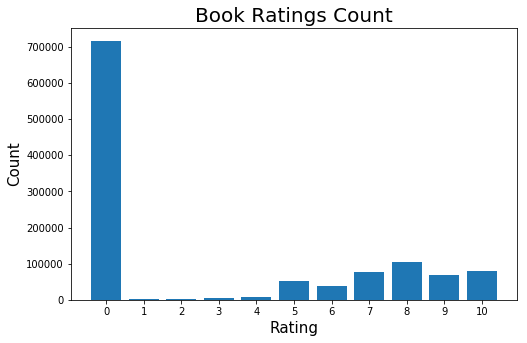

In [155]:
plt.figure(figsize=(8, 5))
plt.bar(x=ratings_df['book_rating'].value_counts().index,
        height=ratings_df['book_rating'].value_counts().values)
plt.title('Book Ratings Count', fontsize=20)
plt.xlabel('Rating', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.xticks(ratings_df['book_rating'].value_counts().index, fontsize=10)
plt.yticks(fontsize=10);

#### User ID

In [137]:
np.asarray(ratings_df['user_id'].value_counts())

array([13602,  7550,  6109, ...,     1,     1,     1])

In [216]:
ratings_df['user_id'].nunique()

105283